# Continuous Control

---
This notebook is based on the code of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.
We will use the same Unity ML-Agents environment.<br>
In this notebook, we will train 20 parallels agents with DDPG

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
#env = UnityEnvironment(file_name='Reacher_Windows_x86_64_one/Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
brain_name 

'ReacherBrain'

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training

Now, we will train our own PPO agent to solve the environment.<br>  When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
from model import Actor_PPO, Critic_PPO

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import copy


### HyperParameters :

In [9]:

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.97            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
NUM_EPOCHS = 20#20
SEED=47
LAMBDA=0.5


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Our **Actor-Critic Neural Network** is implemented here : [model.py](https://github.com/kossowski-pierre/RL_continuous_control/blob/main/model.py)

In [12]:
class Agent():
    
    def __init__(self, state_size, action_size, random_seed, epsilon=0.2, entropy_coef=0.005):
        
        
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = BATCH_SIZE
        self.num_epochs = NUM_EPOCHS
        self.seed = random.seed(random_seed)
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef
        
        self.actor = Actor_PPO(state_size=state_size, action_size=action_size, size1=256).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)
            
        self.critic = Critic_PPO(state_size=state_size,size1=256).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
            
        
        self.memory = Memory()
        self.train=True
        self.actor_loss_history=[]
        self.critic_loss_history=[]
            
    def step(self, states, actions, rewards, next_states, dones, distributions, log_probs):
        states = torch.tensor(states, dtype=torch.float, device=device)
        
        if self.train:
            values = self.critic(states)
            self.memory.add_steps(states, actions, rewards, dones, values, log_probs)# next_states, 
        
    
    def act(self, states, add_noise=False):
        states =torch.tensor(states).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            actions, distributions = self.actor(states)
            log_probs = distributions.log_prob(actions)
            actions = actions.cpu().numpy()
        self.actor.train()
        return np.clip(actions, -1, 1), distributions, log_probs
        
    def reset(self):
        self.noise.reset()
        
    def learn(self,last_states, gamma):
        """Update policy and value parameters using given sequences of experience.
        where:
            self.actor (state) -> action, distribution
            self.critic (state) -> State_Value

        Params
        ======
            last_states (numpy.array): last "next_states" of the sequence  
            gamma (float): discount factor
        """
        last_values = self.critic(torch.FloatTensor(last_states).to(device))

        values_copy = self.memory.values.copy()
        values_copy.append(last_values.cpu().detach().numpy().squeeze())
        returns = self.get_gae(self.memory.rewards, values_copy, self.memory.dones)
        
        self.returns = returns
        actor_losses, critic_losses = [], []
        
        states = torch.FloatTensor(np.array(self.memory.states)).to(device)
        actions = torch.FloatTensor(np.array(self.memory.actions)).to(device)
        log_probs = torch.FloatTensor(np.array(self.memory.log_probs)).to(device)
        values = torch.FloatTensor(np.array(values_copy)).to(device)
        returns = torch.FloatTensor(np.array(returns)).to(device)
        advantages = returns - values[:-1]
        
        advantages = (advantages-advantages.mean())/(advantages.std()+10e-7)
        self.advantages = advantages
        
        for state, action, return_, old_log_prob, old_value, advantage in trajectories_data_generator(
            states=states,
            actions=actions,
            returns=returns,
            log_probs=log_probs,
            values=values,
            advantages=advantages,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            ):
            
            _, new_dist = self.actor(state.view(-1,self.state_size))
            cur_log_prob = new_dist.log_prob(action.view(-1,self.action_size))
            ratio = torch.exp(cur_log_prob - old_log_prob.view(-1,self.action_size))

            advantage = advantage.view(-1,1)

            # compute actor loss
            entropy = new_dist.entropy().mean()
            loss =  advantage * ratio
            clipped_loss = (
                torch.clamp(ratio, 1. - self.epsilon, 1. + self.epsilon)
                 * advantage
                )
            actor_loss = (
                -torch.mean(torch.min(loss, clipped_loss))
                - entropy * self.entropy_coef)
            
            # critic loss
            cur_value = self.critic(state.view(-1,self.state_size))
            critic_loss = F.mse_loss(return_.view(-1,1).detach(), cur_value)
        
            self.critic_optimizer.zero_grad()
        
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
            self.critic_optimizer.step()
        
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)#0.75
            self.actor_optimizer.step()
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
        
        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)
        self.actor_loss_history.append(actor_loss)
        self.critic_loss_history.append(critic_loss)
        

        
    def get_gae(self, rewards, values, dones):
        """Computes a list of estimators of the advantage function at each timestep of the episode
        Params
        ======
            rewards: list of rewards
            values: list of value function values
            dones: list of terminal state flags
        Return
        =======
            discounted sum of rewards
        """
        gae=0
        returns=[]
        for i in reversed(range(len(rewards))):
            delta = rewards[i]+GAMMA*values[i+1]*(1-dones[i])-values[i]
            gae = delta+GAMMA*LAMBDA*(1-dones[i])*gae
            returns.insert(0, gae+values[i])
        return returns
            
                
            
class Memory:
    """Storing the memory of the trajectory (s, a, r ...)."""
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []
    def add_steps(self, states, actions, rewards, dones, values, log_probs):
        self.states.append(states.cpu().detach().numpy())#.cpu().detach().numpy()
        self.actions.append(actions)
        self.rewards.append(np.array(rewards))
        self.dones.append(np.array(dones))
        self.log_probs.append(log_probs.cpu().detach().numpy())
        self.values.append(values.cpu().detach().numpy().squeeze())#.cpu().detach().numpy()
        
        

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []

In [13]:
#source : https://github.com/mandrakedrink/PPO-pytorch/blob/master/ppo/utils.py
def trajectories_data_generator(
    states: torch.Tensor,
    actions: torch.Tensor,
    returns: torch.Tensor,
    log_probs: torch.Tensor,
    values: torch.Tensor,
    advantages: torch.Tensor,
    batch_size,
    num_epochs,
    ):
    """data-generator."""
    data_len = states.size(0)
    for _ in range(num_epochs):
        for _ in range(data_len // batch_size):
            ids = np.random.choice(data_len, batch_size)
            yield states[ids], actions[ids], returns[ids], log_probs[ids], values[ids], advantages[ids]

In [16]:
agent = Agent(state_size, action_size, SEED)

## Training Loop

Episode 83	Average Score: 30.04	Score: 35.95	LossActor: -0.00511 	LossCritic : 0.00016, mean_std : 0.08361
Environment solved in -17 episodes!	Average Score: 30.04, 
Episode 100	Average Score: 31.41	Score: 37.89	LossActor: -0.00506 	LossCritic : 0.00010, mean_std : 0.07319
Episode 199	Average Score: 37.80	Score: 38.51	LossActor: -0.00631 	LossCritic : 0.00007, mean_std : 0.05203

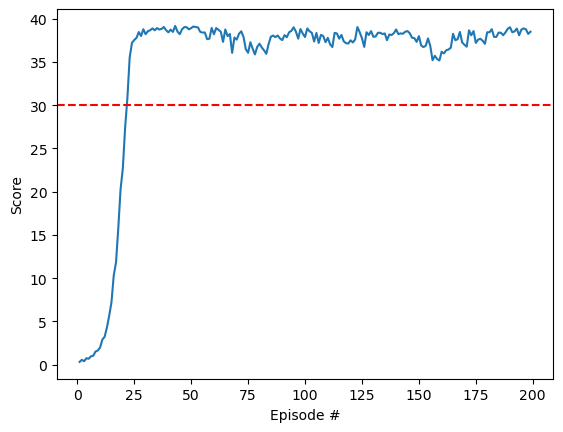

In [17]:
def ppo(n_episodes=200, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
     
    max_score = -np.Inf
    first=True
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions, distributions,log_probs = agent.act(states)#choose an action 
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, distributions,log_probs)#collect events
            # Update weights during the episodes
            if (len(agent.memory.rewards)>agent.batch_size)&(len(agent.memory.rewards)%160==0):
                agent.learn(next_states, GAMMA)
            states = next_states
            score += np.mean(rewards)
            
            
            if np.any(dones):
                break 
        agent.learn(next_states, GAMMA)# Update weights
        agent.memory.clear_memory()#Delete the trajectories
        mean_score_paral = score.mean()
        scores_deque.append(mean_score_paral)
        scores.append(mean_score_paral)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tLossActor: {:.5f} \tLossCritic : {:.5f}, mean_std : {:.5f}'.format(i_episode,
                                                                                                                   np.mean(scores_deque),
                                                                                                                   mean_score_paral,
                                                                                                                   np.mean(agent.actor_loss_history[-min(100, len(agent.actor_loss_history)):]),
                                                                                                                   np.mean(agent.critic_loss_history[-min(100, len(agent.critic_loss_history)):]),
                                                                                                                
                                                                                                                  agent.actor.sigma.mean()), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor.state_dict(), 'checkpoint_actor_ppo_20agent.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic_ppo_20agent.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>30:
            if first==True:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, '.format(
                    i_episode-100, 
                    np.mean(scores_deque)))
                torch.save(agent.actor.state_dict(), 'model_actor_ppo_20agent.pth')
                torch.save(agent.critic.state_dict(), 'model_critic_ppo_20agent.pth')
                first=False
                #break
    return scores

scores = ppo()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.axhline(y=30, color='r', linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

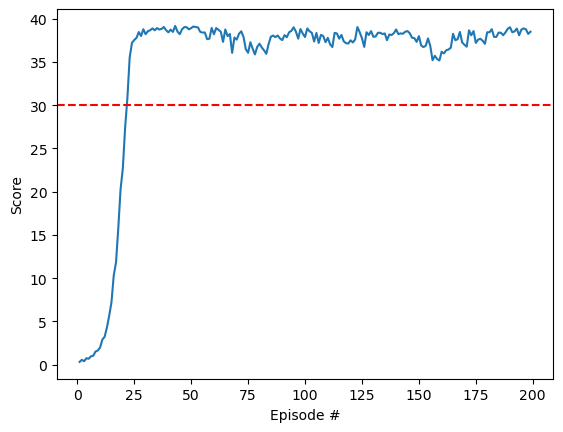

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.axhline(y=30, color='r', linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Let see our Agent

In [19]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions, distributions,log_probs = agent.act(states)#choose an action  # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.26399914473295


In [20]:
env.close()

### Notes :
In this implementation of PPO, we took advice from our previous implementation (with single agent) and made some improvements : 
- weights are updating every 160 steps (previously, we were waiting the end of the episode to update ours networks)
- Std of actor distribution is learn from indepentant parameters cf : model_ppo
- **The range of the standard derivation of the Actor model is reduced**  (because I have observed when the variance was >2, the model stop to learn).So the range of Std is passed from `[np.exp(-1), np.exp(1)]` to `[(np.exp(-1)-0.3)/2, (np.exp(1)-0.3)/2]`. 


### 